# Simulations to Illustrate the Properties of OLS

This notebook uses Monte Carlo simulations to illustrate the properties of OLS. This is *not* asymptotics, but it does hint at what happens in longer and longer samples.

## Load Packages and Extra Functions

The key functions are from the (local) `FinEcmt_OLS` module. We also use one function from the `FinEcmt_TimeSeries` module.

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS
using FinEcmt_TimeSeries: ARMAFilter

In [2]:
using Statistics, Random, Distributions, LaTeXStrings, Plots
Random.seed!(123)             #random number generator starts on this point
NSim = 3000                   #number of iterations in each simulation

3000

## A Function for a Monte Carlo Simulation

`SimulateOLS(CreateYXFn,T,NSim)` makes `NSim` simulations of samples `T` long, where data is created in a function `CreateYXFn(T)` (see below for examples).

In [3]:
"""
    SimulateOLS(CreateYXFn,T,NSim)

Simple function for Monte Carlo simulations of OLS. Data is created
by the `CreateYXFn(T)` function.

"""
function SimulateOLS(CreateYXFn::Function,T,NSim)
  (y,x) = CreateYXFn(T)
  k = size(x,2)
  b = fill(NaN,NSim,k)           #to put the results in
  for i in 1:NSim
    (y,x) = CreateYXFn(T)
    b[i,:] = x\y                 #OLS estimates
  end
  return b
end

SimulateOLS

## Estimating an AR(1) on Samples of Different Lengths (T)

In [4]:
"""
    CreateYXFn_ARMA11(T,ρ,θ)

Create `y,x` for an ARMA(1,1). Set θ=0 to simulate an AR(1)

"""
function CreateYXFn_ARMA11(T,ρ,θ)          #to generate iid (y,x)
  Tb = T + 100                          #100 extra observations, will be cut
  y = ARMAFilter(randn(Tb),[ρ],[θ])         #simulates an ARMA(1)
  x = [ones(T) y[100:end-1]]            #x starts at t=100, y at t=101
  y = y[101:end]
  return y,x
end

CreateYXFn_ARMA11

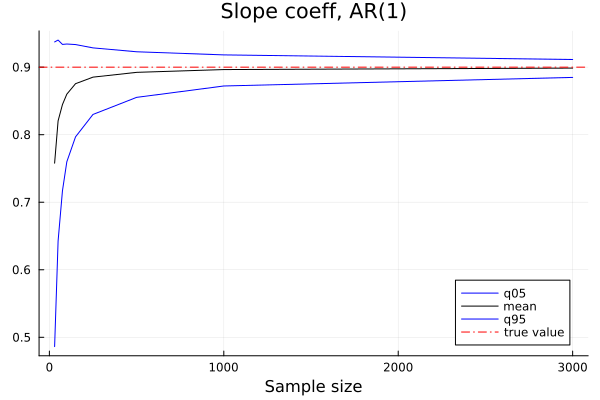

In [5]:
ρ = 0.9
TM = [30,50,75,100,150,250,500,1000,3000]         #calculate for different sample sizes

bM = fill(NaN,NSim,length(TM))
for (i,T) in enumerate(TM)
  local bHat, ρHat
  bHat = SimulateOLS(z -> CreateYXFn_ARMA11(z,ρ,0),T,NSim)    #θ=0 to get AR(1)
  bM[:,i] = bHat[:,2]                   #save the slope coef
end

q05 = [quantile(z,0.05) for z in eachcol(bM)]     #quantiles and mean of estimates
q95 = [quantile(z,0.95) for z in eachcol(bM)]
meanb = mean(bM,dims=1)'

p1 = plot( TM,[q05 meanb q95],
           label = ["q05" "mean" "q95"],
           linecolor = [:blue :black :blue],
           title = "Slope coeff, AR(1)",
           xlabel = "Sample size" )
     hline!([0.9],linecolor=:red,line=:dashdot,label="true value")
display(p1)

## Estimating a Regression with Non-Normal Residuals

In [6]:
"""
    CreateYXFn_Chisq(T,b)

Create `y,x` when the residual has a chisq(2) distribution

"""
function CreateYXFn_Chisq(T,b)          #to generate iid (y,x)
  k = length(b)
  x = [ones(T) 10*randn(T,k-1)]
  u = rand(Chisq(2),T) .- 2
  y = x*b + u
  return y,x
end

CreateYXFn_Chisq

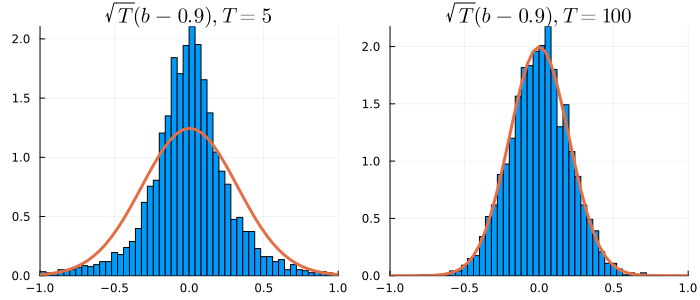

In [7]:
b  = [0,0.9]
TM = [5,100]

bM = fill(NaN,NSim,length(TM))
for (i,T) in enumerate(TM)
  local bHat, ρHat
  bHat = SimulateOLS(z -> CreateYXFn_Chisq(z,b),T,NSim)
  bM[:,i] = bHat[:,2]
end

xGrid = range(-1,1,length=51)
pdfX1 = pdf.(Normal(mean(bM[:,1].-0.9),sqrt(5)*std(bM[:,1])),xGrid)
pdfX2 = pdf.(Normal(mean(bM[:,2].-0.9),sqrt(100)*std(bM[:,2])),xGrid)

p1 = histogram( sqrt(5)*(bM[:,1].-0.9),bins=range(-1,1,length=51),
                normalized = true,
                legend = false,
                xlim = (-1,1),
                title = L"\sqrt{T}(b-0.9), T=5",
                guidefontsize = 8 )
plot!(xGrid,pdfX1,linewidth=3)

p2 = histogram( sqrt(100)*(bM[:,2].-0.9),bins=range(-1,1,length=51),
                normalized = true,
                legend = false,
                xlim = (-1,1),
                title = L"\sqrt{T}(b-0.9), T=100",
                guidefontsize = 8 )
plot!(xGrid,pdfX2,linewidth=3)

pAll = plot(p1,p2,layout=(1,2),size=(700,300))                  #set up subplots
display(pAll)

## Estimating an ARMA(1,1) on Samples of Different Lengths (T)

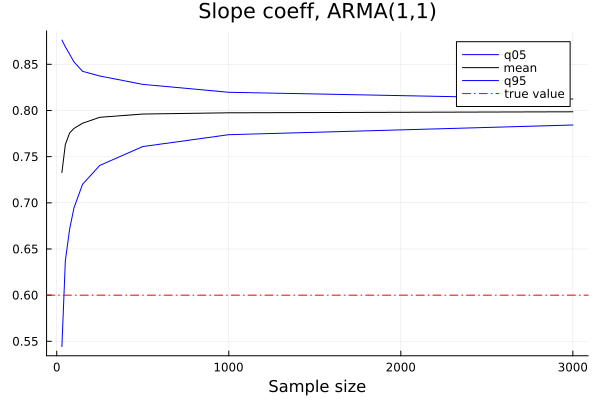

In [8]:
(ρ,θ) = (0.6,0.9)
TM = [30,50,75,100,150,250,500,1000,3000]         #calculate for different sample sizes

bM = fill(NaN,NSim,length(TM))
for (i,T) in enumerate(TM)
  local bHat, ρHat
  bHat = SimulateOLS(z -> CreateYXFn_ARMA11(z,ρ,θ),T,NSim)
  bM[:,i] = bHat[:,2]                   #save the slope coef
end

q05 = [quantile(z,0.05) for z in eachcol(bM)]
q95 = [quantile(z,0.95) for z in eachcol(bM)]
meanb = mean(bM,dims=1)'

p1 = plot( TM,[q05 meanb q95],
           label = ["q05" "mean" "q95"],
           linecolor = [:blue :black :blue],
           title = "Slope coeff, ARMA(1,1)",
           xlabel = "Sample size")
     hline!([0.6],linecolor=:red,line=:dashdot,label="true value")
display(p1)

## Omitted Variables

In [9]:
"""
    CreateYXFn_omitted(T,b)

Create `y,x` when there is an omitted variable

"""
function CreateYXFn_omitted(T,b,θ)
  x = [ones(T) randn(T)*sqrt(0.5)]
  h = θ*x[:,2] + randn(T)
  v = randn(T)*sqrt(4)
  y = x*b + h + v
  return y,x
end

CreateYXFn_omitted

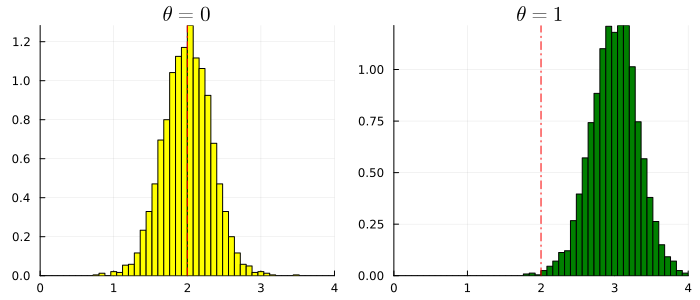

In [10]:

(T,b) = (100,[1,2])
bM0 = SimulateOLS(z -> CreateYXFn_omitted(T,b,0),T,NSim)[:,2]
bM1 = SimulateOLS(z -> CreateYXFn_omitted(T,b,1),T,NSim)[:,2]

p1 = histogram( bM0,bins=range(0,4,length=51),
                normalized = true,
                legend = false,
                color=:yellow,
                xlim = (0,4),
                title = L"\theta=0",
                guidefontsize = 8 )
     vline!([2],linecolor=:red,line=:dashdot)
p2 = histogram( bM1,bins=range(0,4,length=51),
                normalized = true,
                legend = false,
                color=:green,
                xlim = (0,4),
                title = L"\theta=1",
                guidefontsize = 8 )
     vline!([2],linecolor=:red,line=:dashdot)
pAll = plot(p1,p2,layout=(1,2),size=(700,300))
display(pAll)

## Measurement Errors in Regressors

In [11]:
"""
    CreateYXFn_measurement(T,b)

Create `y,x` when there is an omitted variable

"""
function CreateYXFn_measurement(T,b,σₑ)
  w = [ones(T) randn(T)*sqrt(0.5)]
  v = randn(T)*sqrt(4)
  y = w*b + v
  x = w .+ [zeros(T) randn(T)*σₑ]
  return y,x
end

CreateYXFn_measurement

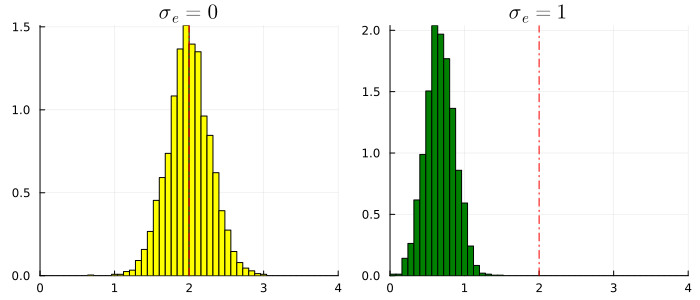

In [12]:
(T,b) = (100,[1,2])
bM0 = SimulateOLS(z -> CreateYXFn_measurement(T,b,0),T,NSim)[:,2]
bM1 = SimulateOLS(z -> CreateYXFn_measurement(T,b,1),T,NSim)[:,2]

p1 = histogram( bM0,bins=range(0,4,length=51),
                normalized = true,
                legend = false,
                color=:yellow,
                xlim = (0,4),
                title = L"\sigma_e=0",
                guidefontsize = 8 )
     vline!([2],linecolor=:red,line=:dashdot)
p2 = histogram( bM1,bins=range(0,4,length=51),
                normalized = true,
                legend = false,
                color=:green,
                xlim = (0,4),
                title = L"\sigma_e=1",
                guidefontsize = 8 )
     vline!([2],linecolor=:red,line=:dashdot)
pAll = plot(p1,p2,layout=(1,2),size=(700,300))
display(pAll)